In [1]:
import pandas as pd
from pyxlsb import open_workbook, convert_date


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import numpy as np
from nltk.corpus import stopwords
import re


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
import unicodedata

from rapidfuzz import process
from rapidfuzz import fuzz

import matplotlib.pyplot as plt 


french_stop_words = set(stopwords.words('french'))
stemmer = FrenchStemmer()




FRENCH_COLORS = set([
    "rouge", "bleu", "vert", "jaune", "noir", "blanc", "orange", "rose", "violet", "marron", "gris", 
    "beige", "turquoise", "or", "argent", "ivoire", "bleu marine", "sarcelle", "bordeaux", "lavande", 
    "pêche", "citron vert", "corail", "cyan", "magenta", "olive", "saumon", "moutarde", "chocolat", 
    "charbon", "indigo", "rubis", "émeraude", "saphir", "doré", "argenté", "brun"
])

file_path = '../../data/ecommerce_sales.xlsb'
sheet_name = '20210614 Ecommerce sales'

In [2]:
def read_xlsb(file_path, sheet_name):
    data = []
    with open_workbook(file_path) as wb:
        with wb.get_sheet(sheet_name) as sheet:
            for idx,row in enumerate(sheet.rows()):
                if idx == 0:
                    data.append([item.v for item in row])
                else:
                    data.append([item.v if item.c != 5 else convert_date(item.v) for item in row ])
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

In [3]:
df = read_xlsb(file_path, sheet_name)

df.head()

,Cod_cmd,Libellé produit,Vendeur,Univers,Nature,Date de commande,Montant cmd,Quantité,Prix transport,Délai transport annoncé
0,182210782.0,Table basse carrée detroit design industriel,Autre vendeur,Canapé Salon Séjour,Table basse,2021-01-20,244.0,4.0,6.67,10.0
1,182082437.0,Ours en peluche géant 150 cm brun,Autre vendeur,Enfant Bébé,Peluche,2021-01-17,28.0,1.0,9.92,10.0
2,182095765.0,Ours en peluche géant 100 cm blanc,Autre vendeur,Enfant Bébé,Peluche,2021-01-18,15.0,1.0,9.92,10.0
3,182615392.0,Lot de 4 chaises mia noires pour salle à manger,Autre vendeur,Canapé Salon Séjour,Chaise,2021-01-23,385.0,2.0,20.75,10.0
4,184222081.0,Meuble tv falko bois blanc et gris,Autre vendeur,Canapé Salon Séjour,Meuble tv,2021-02-11,61.0,1.0,19.08,10.0


In [4]:
unique_categories = df['Nature'].unique()

print(len(unique_categories))

597


In [5]:
nature_counts = df['Nature'].value_counts(dropna=False)
print(nature_counts)

Nature
Matelas                35593
Lit adulte             21133
Meuble à chaussures    19105
Chaise                 15591
Bureau                 15409
                       ...  
Bûcher                     1
Facade de cuisine          1
défroisseur                1
Défroisseur                1
Fendeur de bûches          1
Name: count, Length: 597, dtype: int64


In [6]:
# check for null Nature column
print(df['Libellé produit'].isnull().sum(), df['Nature'].isnull().sum())


0 11745


In [7]:
df[df['Nature'].isnull()]

,Cod_cmd,Libellé produit,Vendeur,Univers,Nature,Date de commande,Montant cmd,Quantité,Prix transport,Délai transport annoncé
2880,182365338.0,1 an d assistance Téléphonique PC,Vendeur 1,None,None,2021-01-21,15.0,1.0,0.0,NaN
2881,181740179.0,1 an d assistance Téléphonique PC,Vendeur 1,None,None,2021-01-11,15.0,1.0,0.0,NaN
2913,182064688.0,Adhérer au programme fidélité Ma Carte Confo +,Vendeur 1,None,None,2021-01-17,15.0,1.0,0.0,NaN
2945,184295805.0,Adhérer au programme fidélité Ma Carte Confo +,Vendeur 1,None,None,2021-02-12,15.0,1.0,0.0,NaN
2950,186130407.0,Adhérer au programme fidélité Ma Carte Confo +,Vendeur 1,None,None,2021-03-14,15.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
524493,187044149.0,Reprise ancien produit,Vendeur 1,None,None,2021-03-29,15.0,1.0,0.0,NaN
524494,211136318.0,Reprise ancien produit,Vendeur 1,None,None,2021-03-31,15.0,1.0,0.0,NaN
524495,187041940.0,Reprise ancien produit,Vendeur 1,None,None,2021-03-29,15.0,1.0,0.0,NaN
524496,187000717.0,Reprise ancien produit,Vendeur 1,None,None,2021-03-29,15.0,1.0,0.0,NaN


In [8]:
# Its seems Service based products are Mapped as None Category, As we are not authorize to create a new category, we will drop the none values 
category_data = df[['Libellé produit','Nature']]

category_data = category_data.dropna(subset=['Nature']).reset_index(drop=True)

In [9]:
class ProductInfoRemover:
    def __init__(self):
        self.dimension_pattern = re.compile(r'(\d+(?:[.,]\d+)?)\s*(?:x|×)\s*(\d+(?:[.,]\d+)?)\s*(?:cm|m)?', re.IGNORECASE)
        self.single_dim_pattern = re.compile(r'(\d+(?:[.,]\d+)?)\s*(?:cm|m)', re.IGNORECASE)
        self.word_split_pattern = re.compile(r'\b\w+\b')
        self.color_patterns = {color: re.compile(rf'\b{color}(?:s|es|e)?\b', re.IGNORECASE) for color in FRENCH_COLORS}

    def remove_info(self, description):
        desc_lower = self.preclean_apply(description)
        cleaned_description = self.remove_dimensions(desc_lower)
        cleaned_description = self.remove_colors(cleaned_description)
        cleaned_description = re.sub(r'\s+', ' ', cleaned_description).strip()
        return cleaned_description
    
    def preclean_apply(self, text):
        text = self.to_lower(text)
        text = self.remove_accents(text)
        #text = self.remove_numbers(text)
        return text

    def remove_dimensions(self, desc_lower):
        desc_lower = self.dimension_pattern.sub('', desc_lower)
        desc_lower = self.single_dim_pattern.sub('', desc_lower)
        return desc_lower
    
    def find_matching_colors(self, desc_lower):
        words = desc_lower.split()
        matching_words = []
        for word in words:
            if any(color in word for color in FRENCH_COLORS):
                matching_words.append(word)
        return matching_words
    
    def remove_colors(self, desc_lower):
        matching_words = self.find_matching_colors(desc_lower)
        for word in matching_words:
            sim = process.extractOne(word, FRENCH_COLORS, scorer=fuzz.ratio, score_cutoff=75)
            if sim:
                color_pattern = re.compile(rf'\b{sim[0]}\b', re.IGNORECASE)
                desc_lower = color_pattern.sub('', desc_lower)
        return desc_lower
    
    def remove_numbers(self, desc_lower):
        return re.sub(r'\b\d+\b', '', desc_lower)

    def to_lower(self,text):
        return str(text).lower()

    def remove_accents(self, text):
        return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')


remover = ProductInfoRemover()

category_data['Libellé produit'] = category_data['Libellé produit'].apply(remover.preclean_apply)
category_data['Nature'] = category_data['Nature'].apply(remover.preclean_apply)
    

In [10]:
category_data_unique_title_nature = category_data.drop_duplicates(subset=['Libellé produit', 'Nature']).reset_index(drop=True)
category_data_unique_title = category_data.drop_duplicates(subset=['Libellé produit']).reset_index(drop=True)

In [11]:
print(f'Total length unique title and nature data is {len(category_data_unique_title_nature)}')
print(f'Total length unique title data is {len(category_data_unique_title)}')
print(f'difference of unique title and unique title and nature { len(category_data_unique_title_nature) - len(category_data_unique_title)}')


Total length unique title and nature data is 58003
Total length unique title data is 55811
difference of unique title and unique title and nature 2192


In [12]:
category_data_unique_title

,Libellé produit,Nature
0,table basse carree detroit design industriel,table basse
1,ours en peluche geant 150 cm brun,peluche
2,ours en peluche geant 100 cm blanc,peluche
3,lot de 4 chaises mia noires pour salle a manger,chaise
4,meuble tv falko bois blanc et gris,meuble tv
...,...,...
55806,table basse wonderland table basse extensible ...,table basse
55807,refrigerateur 2 portes 207l froid statique oce...,refrigerateur
55808,nappe antitache ronde infroissable et 100 poly...,linge de table
55809,good morning housse de couette pour enfants da...,housse de couette


In [13]:

# Function to remove special charaters, tokenize and remove stop words
def clean_and_tokenize(text):
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text, language='french')
    tokens = [stemmer.stem(word) for word in tokens if word not in french_stop_words]
    return tokens

# Function to check if any word in the category is present in the title
def check_category_in_title(row):
    title_tokens = clean_and_tokenize(row['Libellé produit'])
    category_tokens = clean_and_tokenize(row['Nature'])
    return 'Yes' if any(category_token in title_tokens for category_token in category_tokens) else 'No'

In [14]:
category_data_unique_title['category_in_title'] = category_data_unique_title.apply(check_category_in_title, axis = 1)

In [15]:
category_data_unique_title_no = category_data_unique_title[category_data_unique_title['category_in_title'] == 'No']
category_data_unique_title_yes = category_data_unique_title[category_data_unique_title['category_in_title'] == 'Yes']

In [16]:
category_data_unique_title_no

,Libellé produit,Nature,category_in_title
7,tagere a double position tania bois imitation...,bibliotheque,No
9,console vintage leoni motifs graphiques,bureau,No
21,tagere a double position tania bois blanc l 1...,bibliotheque,No
24,lot de 3 etageres murales grises,bibliotheque,No
44,tagere echelle scandinave klara bois blanc et...,bibliotheque,No
...,...,...,...
55791,apple watch series 5 nike gps bo tier 44mm alu...,acc telephonie,No
55792,apple watch serie 3 gps 42 mm argent avec le s...,acc telephonie,No
55794,rafra chisseur d air reversible htw serie alp ...,climatiseur,No
55801,mousse nettoyante super active wc clean,accessoire jardin,No


In [17]:
def find_category_positions(row):
    title_tokens = clean_and_tokenize(row['Libellé produit'])
    category_tokens = clean_and_tokenize(row['Nature'])
    positions = [idx for idx, token in enumerate(title_tokens) if token in category_tokens]
    return positions

# Apply the function to get positions for 'Yes' cases
category_data_unique_title_yes['category_positions'] = category_data_unique_title_yes.apply(find_category_positions, axis=1)


C:\Users\jatin\AppData\Local\Temp\ipykernel_5876\994035872.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data_unique_title_yes['category_positions'] = category_data_unique_title_yes.apply(find_category_positions, axis=1)


In [18]:
all_positions = [position for positions in category_data_unique_title_yes['category_positions'] for position in positions]

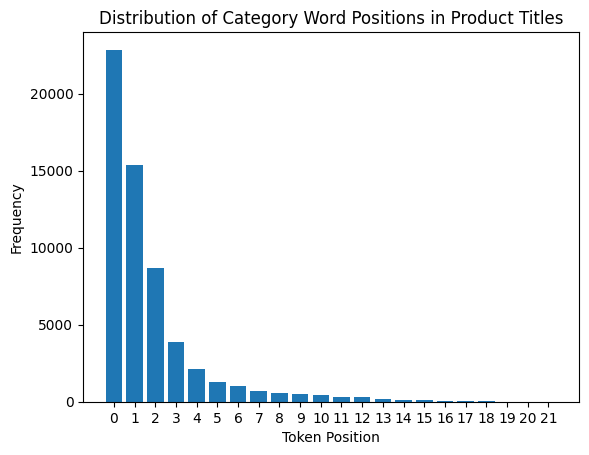

In [19]:
plt.hist(all_positions, bins=range(0, max(all_positions)+2), align='left', rwidth=0.8)
plt.xlabel('Token Position')
plt.ylabel('Frequency')
plt.title('Distribution of Category Word Positions in Product Titles')
plt.xticks(range(0, max(all_positions)+1))
plt.show()

<Axes: xlabel='Nature'>

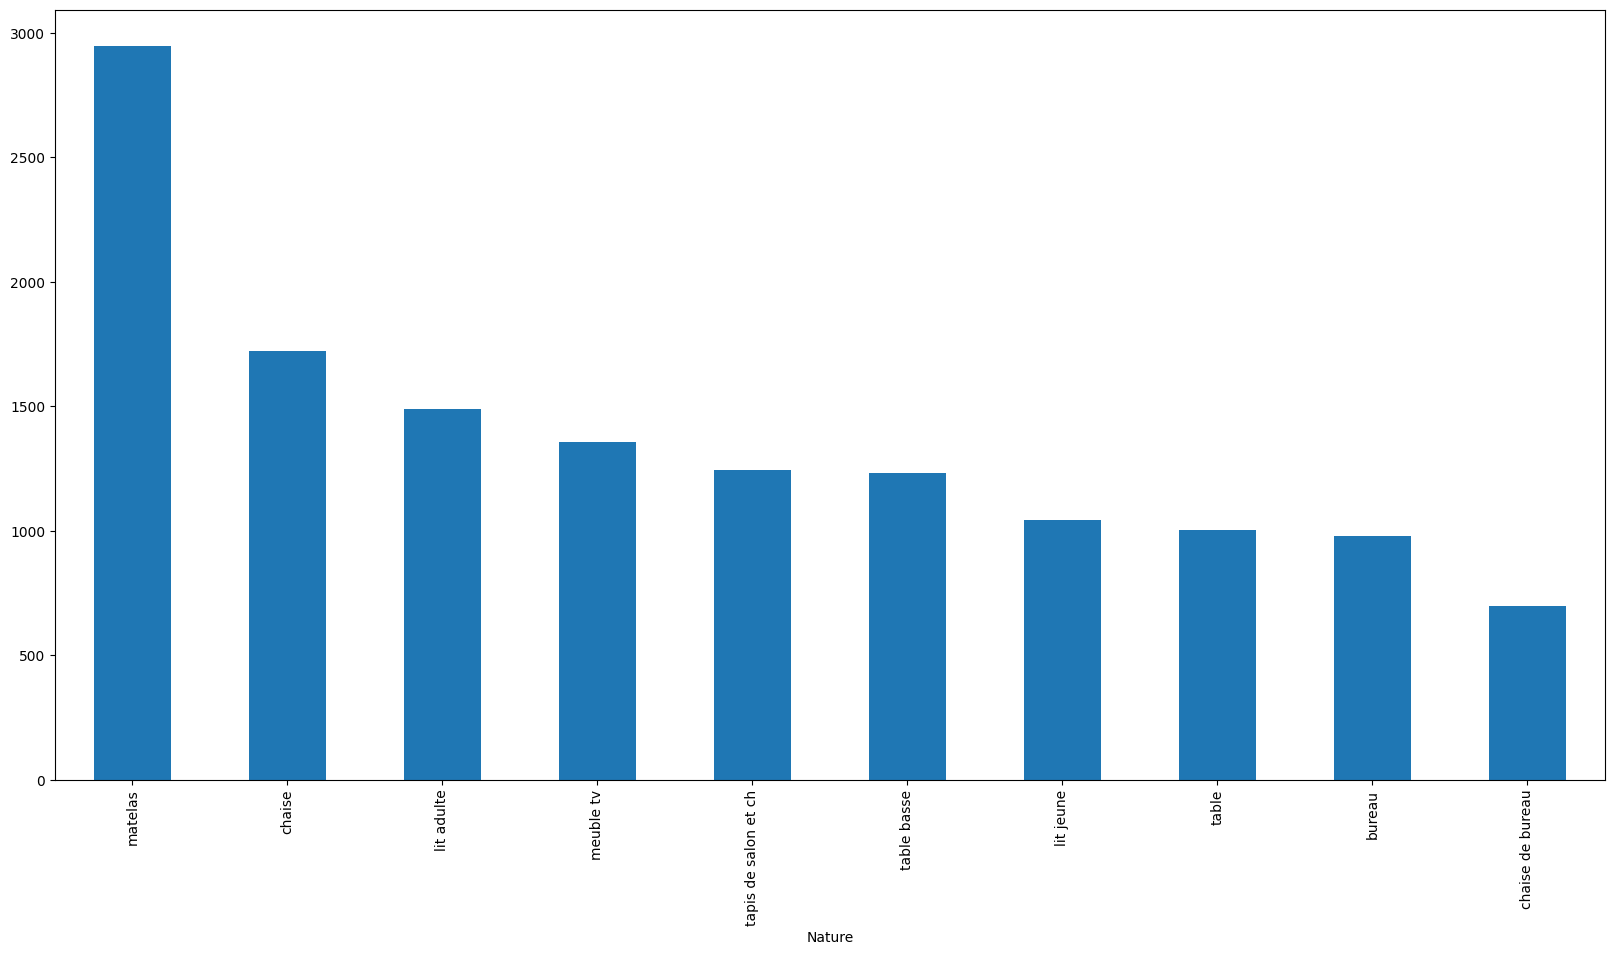

In [20]:
# plot distibution of category with category in title as yes

category_data_unique_title_yes['Nature'].value_counts().head(10).plot(kind='bar', figsize=(20, 10))

<Axes: xlabel='Nature'>

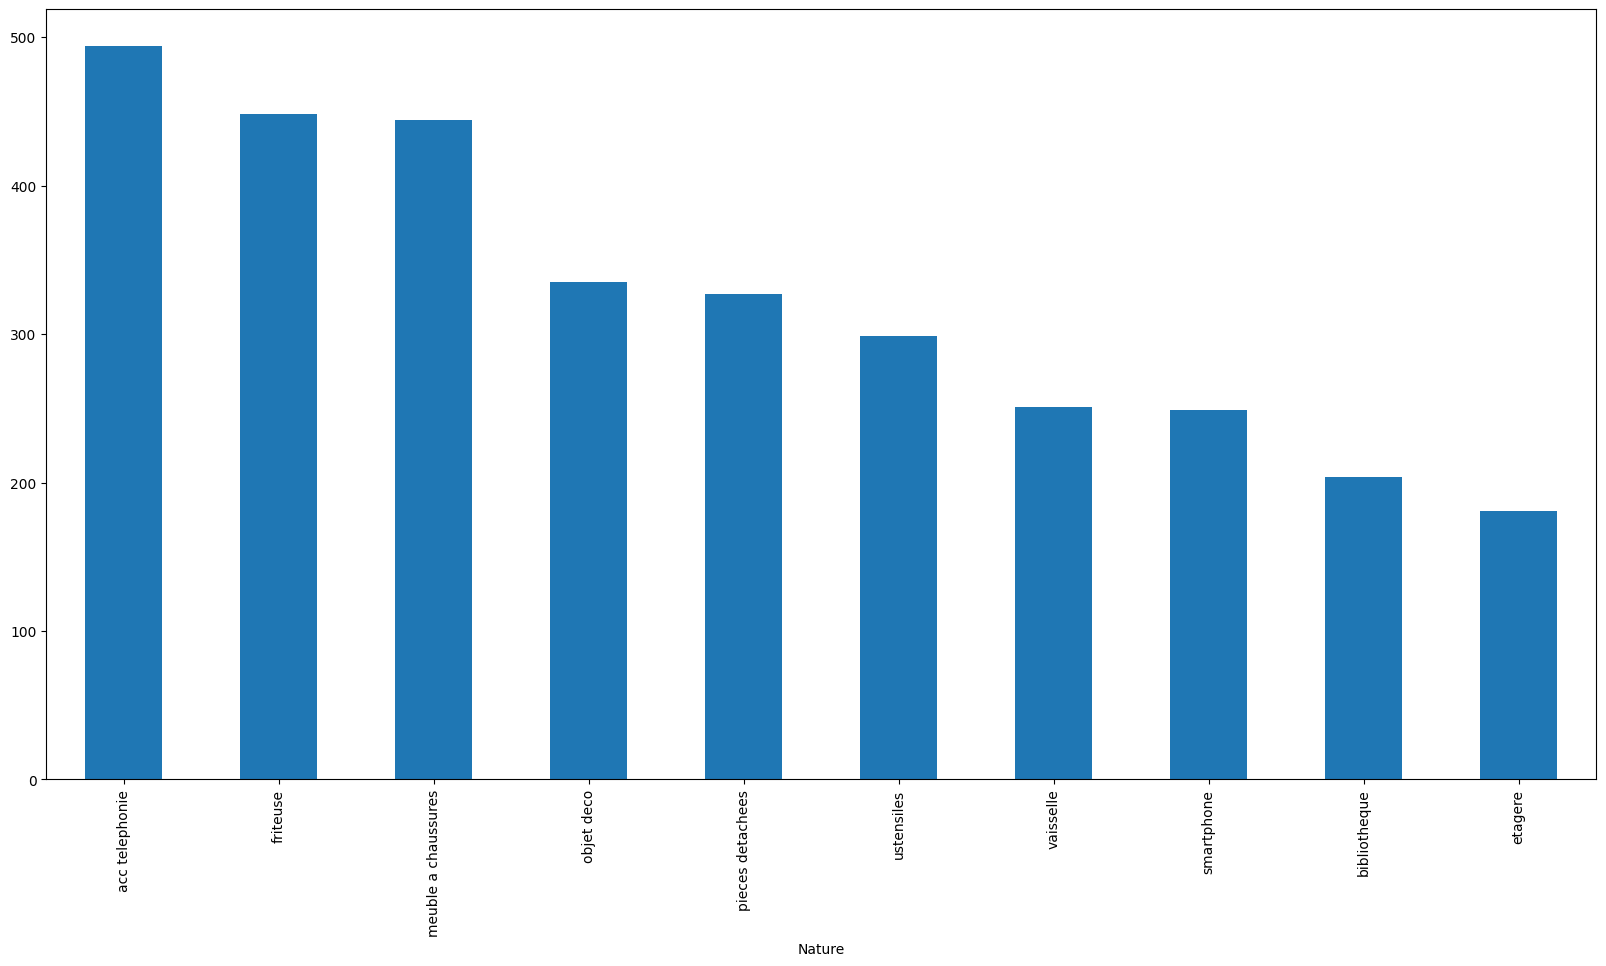

In [21]:
category_data_unique_title_no['Nature'].value_counts().head(10).plot(kind='bar', figsize=(20, 10))

In [24]:
category_data_unique_title_yes.to_csv('../../data/category_data_unique_title_yes.csv', index=False)

In [22]:
category_data_unique_title.to_csv('../../data/category_data_unique_title.csv', index=False)
category_data_unique_title_nature.to_csv('../../data/category_data_unique_title_nature.csv',index=False)


In [23]:
category_data.to_csv('../../data/category_data.csv', index = False)